## Setup & Imports

In [33]:
import sys

sys.path.insert(0, "..")

import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from src.environment import InventoryEnvironment
from src.agents import AgentsLoader
from src.baseline import create_sS_policy
from src.mdp import RewardFunction
from src.simulation import InventorySimulation
from src.mdp import sample_initial_state
from src.seeds import generate_seeds

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Configuration

In [34]:
SIM_DAYS = 1000  # Days per replication (about 3 years)
NUM_REPLICATIONS = 100  # Number of independent runs

# Environment config
K = 25
Q_MAX = 30

WELCH_SEEDS = generate_seeds(NUM_REPLICATIONS, start_index=100)

WINDOW_SIZE = 25

BASELINE_POLICY = create_sS_policy((20, 38), (19, 37))

print(f"📋 Configuration:")
print(f"   Simulation: {SIM_DAYS} days × {NUM_REPLICATIONS} replications")
print(f"   Environment: k={K}, Q_max={Q_MAX}")
print(f"   Smoothing window: {WINDOW_SIZE} days")

📋 Configuration:
   Simulation: 1000 days × 100 replications
   Environment: k=25, Q_max=30
   Smoothing window: 25 days


## RL Agents Configuration

In [35]:
# Create environment for agent loading
env = InventoryEnvironment(
    k=K,
    Q_max=Q_MAX,
    episode_length=365,
    random_seed=42,  # Dummy seed for initialization
)

loader = AgentsLoader(env, models_dir=Path("./models"))

available_models = loader.list_available_models()
print(f"\n📦 Available trained models:")
for model in available_models:
    print(f"   • {model}")

# Select which RL agents to analyze
# Modify this list based on your trained models
RL_AGENTS = [
    #"dqn_model",
    "dqn_k25_Qmax30_agent",
    #"dqn_Qmax30_baseline_agent",
    #"dqn_Qmax30_env_trainfreq2",
    #"dqn_baseline_env_trainfreq2_1",
    #"dqn_baseline_env_trainfreq2",

]

print(f"\n🤖 RL Agents to analyze:")
for agent_name in RL_AGENTS:
    print(f"   • {agent_name}")


📦 Available trained models:
   • dqn_Qmax30_baseline_agent
   • dqn_Qmax30_env_trainfreq2
   • dqn_Qmax35_baseline_agent
   • dqn_Qmax35_trainfreq2_agent
   • dqn_baseline
   • dqn_baseline_env_lr1e-5
   • dqn_baseline_env_lr3e-4
   • dqn_baseline_env_net512x512
   • dqn_baseline_env_trainfreq1
   • dqn_baseline_env_trainfreq2
   • dqn_baseline_env_trainfreq2_1
   • dqn_k15_baseline_agent
   • dqn_k25_Qmax30_agent
   • dqn_k25_baseline_agent
   • dqn_model

🤖 RL Agents to analyze:
   • dqn_k25_Qmax30_agent


## 1. Baseline (s,S) Policy - Welch Analysis

In [36]:
print("="*80)
print("Running Baseline (s,S) Policy")
print("="*80)

baseline_costs = []  # Each element is a list of daily costs for one replication
reward_fn = RewardFunction()

start_time = time.time()

for seed in tqdm(WELCH_SEEDS, desc="Baseline replications"):
    rng = np.random.default_rng(seed)
    
    # Initialize simulation
    sim = InventorySimulation(random_state=rng)
    initial_state = sample_initial_state(steady_state=(11, 13), randomness=5, rng=rng)
    sim.reset(initial_state)
    
    daily_costs = []
    
    # Run simulation
    for _ in range(SIM_DAYS):
        state = sim.get_current_state()
        action = BASELINE_POLICY(state)
        new_state, _ = sim.execute_daily_decision(action)
        
        costs = reward_fn.calculate_costs(new_state, action)
        daily_costs.append(costs.total_cost)
    
    baseline_costs.append(daily_costs)

elapsed = time.time() - start_time
print(f"\n✅ Baseline complete in {elapsed:.1f}s ({elapsed/NUM_REPLICATIONS:.2f}s per replication)")

Running Baseline (s,S) Policy


Baseline replications: 100%|██████████| 100/100 [00:01<00:00, 51.89it/s]


✅ Baseline complete in 1.9s (0.02s per replication)


## 2. RL Agents - Welch Analysis

In [37]:
# Storage for all RL agent costs
rl_agent_costs = {}  # {agent_name: [[day1, day2, ...], [day1, day2, ...], ...]}

for agent_name in RL_AGENTS:
    print(f"\n{'='*80}")
    print(f"Running RL Agent: {agent_name}")
    print(f"{'='*80}")
    
    # Load agent once
    agent = loader.load_agent(agent_name, agent_type='dqn')
    
    agent_costs = []
    start_time = time.time()
    
    for seed in tqdm(WELCH_SEEDS, desc=f"{agent_name} replications"):
        eval_env = InventoryEnvironment(
            k=K,
            Q_max=Q_MAX,
            episode_length=SIM_DAYS,
            random_seed=seed,
        )
        
        obs, _ = eval_env.reset()
        daily_costs = []
        
        done = False
        while not done:
            action = agent.select_action(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            
            daily_costs.append(-reward)
            done = terminated or truncated
        
        agent_costs.append(daily_costs)
    
    elapsed = time.time() - start_time
    rl_agent_costs[agent_name] = agent_costs
    
print(f"\n{'='*80}")
print(f"✅ All agents analyzed!")
print(f"{'='*80}")


Running RL Agent: dqn_k25_Qmax30_agent
📥 Loading DQN agent: dqn_k25_Qmax30_agent...
✅ Agent loaded successfully


dqn_k25_Qmax30_agent replications: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


✅ All agents analyzed!


## 3. Compute Average Daily Costs Across Replications

In [38]:
# Average across replications for baseline
baseline_avg_daily = [sum(day_costs) / NUM_REPLICATIONS 
                      for day_costs in zip(*baseline_costs)]

# Average across replications for RL agents
rl_avg_daily = {}
for agent_name, costs in rl_agent_costs.items():
    rl_avg_daily[agent_name] = [sum(day_costs) / NUM_REPLICATIONS 
                                 for day_costs in zip(*costs)]

print(f"✅ Computed average daily costs across {NUM_REPLICATIONS} replications")

✅ Computed average daily costs across 100 replications


## 4. Plot Raw Average Daily Costs

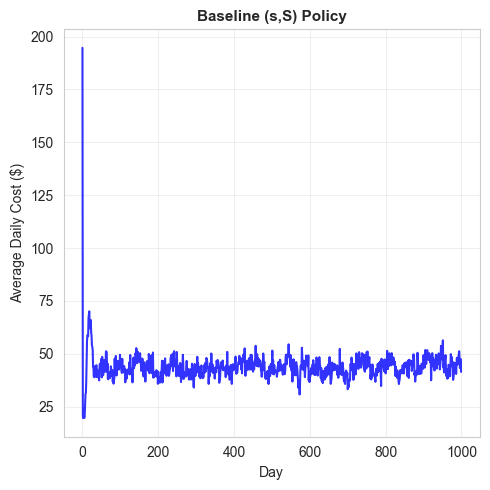

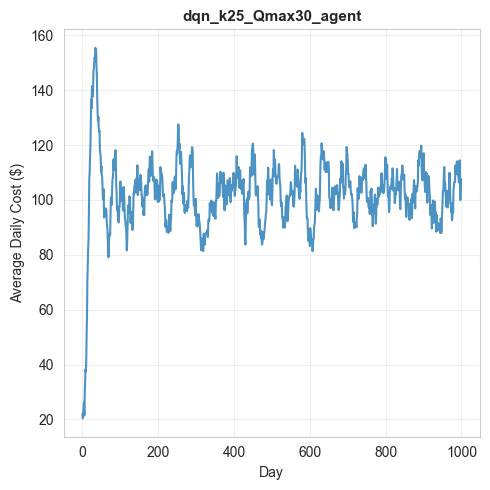

In [39]:
# Individual plots for detailed inspection
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_avg_daily, linewidth=1.5, alpha=0.8, color="blue")
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Average Daily Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) Policy", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent separately
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(rl_avg_daily[agent_name], linewidth=1.5, alpha=0.8, color=color)
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Average Daily Cost ($)", fontsize=10)
    ax.set_title(agent_name, fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Apply Moving Average (Welch's Smoothing)

In [40]:
def compute_moving_average(data: list[float], window_size: int) -> list[float]:
    """
    Compute centered moving average.
    
    Args:
        data: Daily cost values
        window_size: Half-width of window (total window = 2*window_size + 1)
    
    Returns:
        Smoothed values
    """
    moving_avg = []
    
    for i in range(len(data) - window_size):
        if i < window_size:
            # Use expanding window at start
            moving_avg.append(sum(data[:2 * i + 1]) / (2 * i + 1))
        else:
            # Use full centered window
            window = data[i - window_size:i + window_size + 1]
            moving_avg.append(sum(window) / len(window))
    
    return moving_avg


# Apply smoothing
baseline_smoothed = compute_moving_average(baseline_avg_daily, WINDOW_SIZE)

rl_smoothed = {}
for agent_name in RL_AGENTS:
    rl_smoothed[agent_name] = compute_moving_average(rl_avg_daily[agent_name], WINDOW_SIZE)

print(f"✅ Applied moving average with window size {WINDOW_SIZE}")

✅ Applied moving average with window size 25


## 6. Plot Smoothed Curves (Welch Procedure)

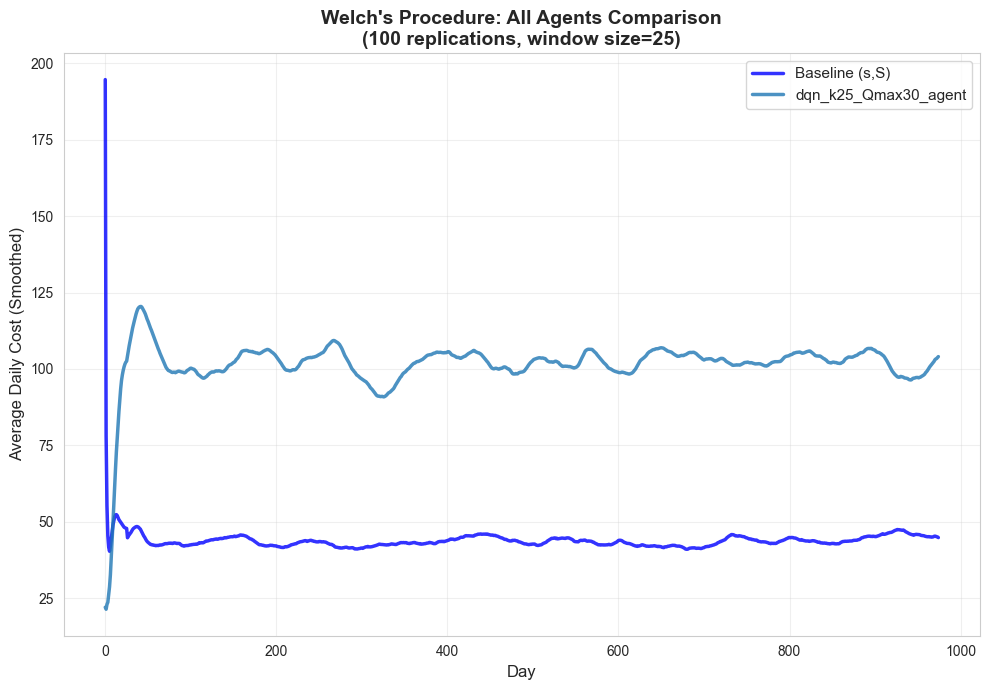

In [41]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot baseline
ax.plot(
    baseline_smoothed, label="Baseline (s,S)", linewidth=2.5, alpha=0.8, color="blue"
)

# Plot RL agents
for agent_name in RL_AGENTS:
    ax.plot(rl_smoothed[agent_name], label=agent_name, linewidth=2.5, alpha=0.8)

ax.set_xlabel("Day", fontsize=12)
ax.set_ylabel("Average Daily Cost (Smoothed)", fontsize=12)
ax.set_title(
    f"Welch's Procedure: All Agents Comparison\n"
    f"({NUM_REPLICATIONS} replications, window size={WINDOW_SIZE})",
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="best")
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

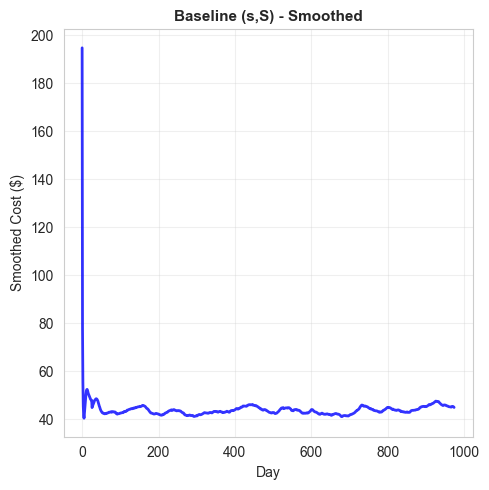

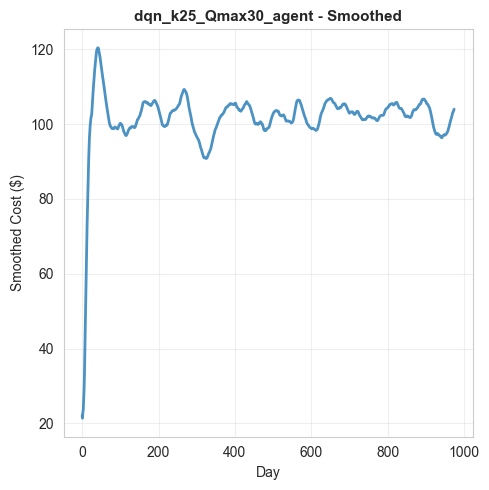

In [42]:
# Plot baseline
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color="blue")
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) - Smoothed", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(5, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(rl_smoothed[agent_name], linewidth=2, alpha=0.8, color=color)
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
    ax.set_title(f"{agent_name} - Smoothed", fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Automatic Warmup Detection

Use 5% tolerance algorithm to automatically detect warmup length.

In [43]:
def detect_warmup_length(smoothed_data: list[float], tolerance: float = 0.05) -> int:
    """
    Automatically detect warmup length using plateau detection.

    Args:
        smoothed_data: Smoothed daily cost curve
        tolerance: Relative tolerance for plateau (default: 5%)

    Returns:
        Warmup length in days
    """
    if len(smoothed_data) < 100:
        return len(smoothed_data) // 2

    # Use second half as steady-state estimate
    steady_state_start = len(smoothed_data) // 2
    steady_state_mean = np.mean(smoothed_data[steady_state_start:])
    threshold = tolerance * steady_state_mean

    # Find first point where cost stays within tolerance
    for i in range(50, len(smoothed_data) - 50):
        window = smoothed_data[i : i + 50]
        if all(abs(val - steady_state_mean) <= threshold for val in window):
            return i

    # Fallback
    return len(smoothed_data) // 2


# Detect warmup for all policies
baseline_warmup = detect_warmup_length(baseline_smoothed)

rl_warmups = {}
for agent_name in RL_AGENTS:
    rl_warmups[agent_name] = detect_warmup_length(rl_smoothed[agent_name])

print("🔍 Detected Warmup Lengths:")
print(f"   Baseline (s,S): {baseline_warmup} days")
for agent_name in RL_AGENTS:
    print(f"   {agent_name}: {rl_warmups[agent_name]} days")

🔍 Detected Warmup Lengths:
   Baseline (s,S): 50 days
   dqn_k25_Qmax30_agent: 61 days


## 8. Plot with Detected Warmup Periods

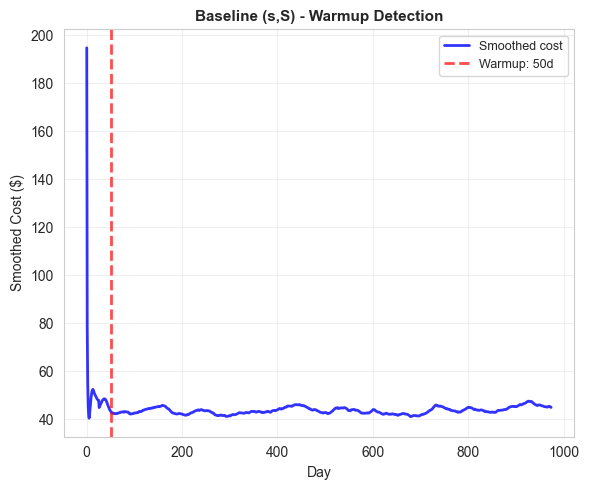

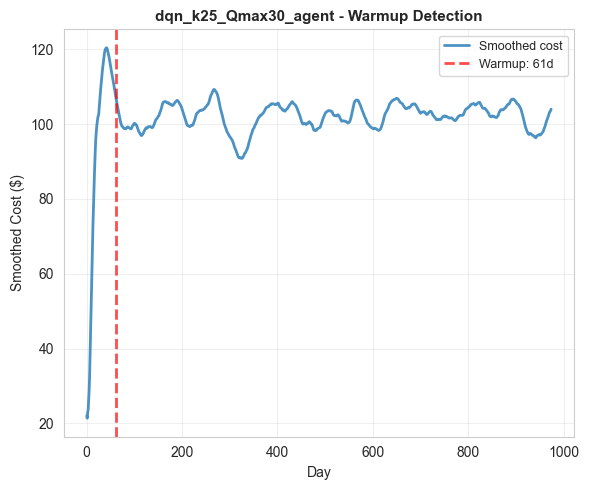

In [44]:
# Plot baseline with warmup
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(baseline_smoothed, linewidth=2, alpha=0.8, color="blue", label="Smoothed cost")
ax.axvline(
    baseline_warmup,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label=f"Warmup: {baseline_warmup}d",
)
ax.set_xlabel("Day", fontsize=10)
ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
ax.set_title("Baseline (s,S) - Warmup Detection", fontsize=11, fontweight="bold")
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot each RL agent with warmup
cmap = plt.colormaps.get_cmap("tab10")
for agent_name in RL_AGENTS:
    fig, ax = plt.subplots(figsize=(6, 5))
    color = cmap(RL_AGENTS.index(agent_name) % cmap.N)
    ax.plot(
        rl_smoothed[agent_name],
        linewidth=2,
        alpha=0.8,
        color=color,
        label="Smoothed cost",
    )
    ax.axvline(
        rl_warmups[agent_name],
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
        label=f"Warmup: {rl_warmups[agent_name]}d",
    )
    ax.set_xlabel("Day", fontsize=10)
    ax.set_ylabel("Smoothed Cost ($)", fontsize=10)
    ax.set_title(f"{agent_name} - Warmup Detection", fontsize=11, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Steady-State Cost Comparison

Compare performance after excluding warmup period.

In [45]:
def compute_steady_state_metrics(costs_data: list[list[float]], warmup: int) -> dict:
    """
    Compute steady-state cost metrics.

    Args:
        costs_data: [[day1, day2, ...], ...] for all replications
        warmup: Warmup period to exclude

    Returns:
        Dictionary with mean, std, ci_95
    """
    # Extract steady-state costs (after warmup) for each replication
    steady_state_costs = [np.mean(replication[warmup:]) for replication in costs_data]

    mean = np.mean(steady_state_costs)
    std = np.std(steady_state_costs)
    ci_95 = 1.96 * std / np.sqrt(len(steady_state_costs))

    return {
        "mean": mean,
        "std": std,
        "ci_95": ci_95,
        "per_replication": steady_state_costs,
    }


baseline_metrics = compute_steady_state_metrics(baseline_costs, baseline_warmup)

rl_metrics = {}
for agent_name in RL_AGENTS:
    rl_metrics[agent_name] = compute_steady_state_metrics(
        rl_agent_costs[agent_name], rl_warmups[agent_name]
    )


comparison_data = []

# Add baseline
comparison_data.append(
    {
        "Policy": "Baseline (s,S)",
        "Warmup (days)": baseline_warmup,
        "Mean Cost ($)": baseline_metrics["mean"],
        "Std ($)": baseline_metrics["std"],
        "95% CI (±$)": baseline_metrics["ci_95"],
        "vs Baseline (%)": 0.0,
    }
)

# Add RL agents
for agent_name in RL_AGENTS:
    metrics = rl_metrics[agent_name]
    improvement = (
        (baseline_metrics["mean"] - metrics["mean"]) / baseline_metrics["mean"]
    ) * 100

    comparison_data.append(
        {
            "Policy": agent_name,
            "Warmup (days)": rl_warmups[agent_name],
            "Mean Cost ($)": metrics["mean"],
            "Std ($)": metrics["std"],
            "95% CI (±$)": metrics["ci_95"],
            "vs Baseline (%)": improvement,
        }
    )

df_comparison = pd.DataFrame(comparison_data)

print("=" * 120)
print("STEADY-STATE COST COMPARISON (Welch's Procedure)")
print("=" * 120)

display(
    df_comparison.style.format(
        {
            "Mean Cost ($)": "{:.2f}",
            "Std ($)": "{:.2f}",
            "95% CI (±$)": "{:.2f}",
            "vs Baseline (%)": "{:+.2f}",
        }
    )
    .background_gradient(subset=["Mean Cost ($)"], cmap="RdYlGn_r")
    .background_gradient(subset=["vs Baseline (%)"], cmap="RdYlGn")
)

STEADY-STATE COST COMPARISON (Welch's Procedure)


,Policy,Warmup (days),Mean Cost ($),Std ($),95% CI (±$),vs Baseline (%)
0,"Baseline (s,S)",50,43.57,3.31,0.65,+0.00
1,dqn_k25_Qmax30_agent,61,102.06,6.01,1.18,-134.26


## 10. Visualization: Cost Comparison

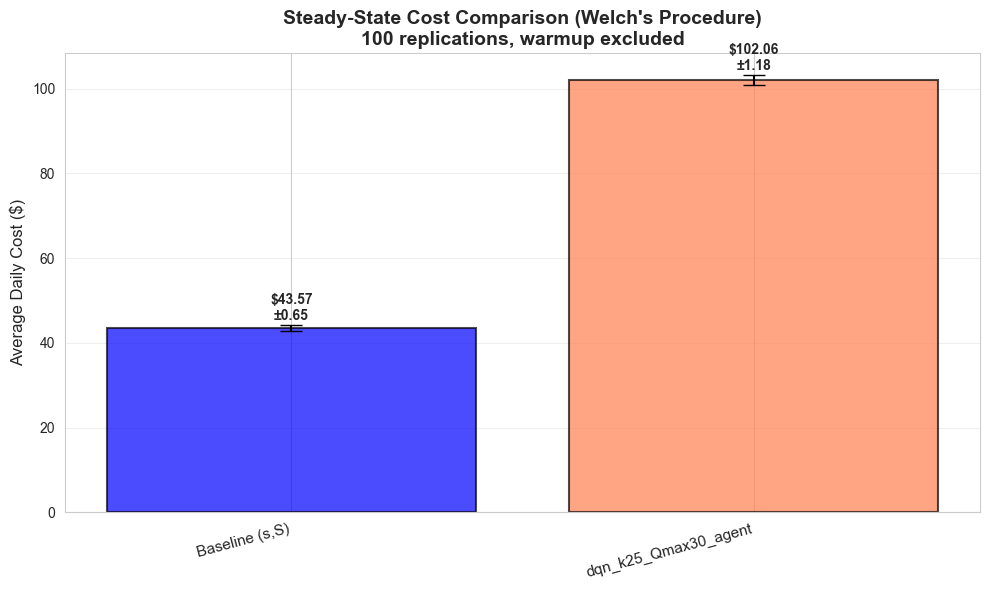

In [46]:
# Prepare data for visualization
policies = ['Baseline (s,S)'] + RL_AGENTS
means = [baseline_metrics['mean']] + [rl_metrics[name]['mean'] for name in RL_AGENTS]
cis = [baseline_metrics['ci_95']] + [rl_metrics[name]['ci_95'] for name in RL_AGENTS]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue'] + ['coral'] * len(RL_AGENTS)
bars = ax.bar(range(len(policies)), means, yerr=cis, 
              capsize=8, alpha=0.7, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(policies)))
ax.set_xticklabels(policies, fontsize=11, rotation=15, ha='right')
ax.set_ylabel('Average Daily Cost ($)', fontsize=12)
ax.set_title(
    'Steady-State Cost Comparison (Welch\'s Procedure)\n'
    f'{NUM_REPLICATIONS} replications, warmup excluded',
    fontsize=14, fontweight='bold'
)

# Add value labels on bars
for i, (mean, ci) in enumerate(zip(means, cis)):
    ax.text(i, mean + ci + 0.5, f'${mean:.2f}\n±{ci:.2f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 11. Export Results

In [47]:
export_data = {
    "configuration": {
        "sim_days": SIM_DAYS,
        "num_replications": NUM_REPLICATIONS,
        "window_size": WINDOW_SIZE,
        "k": K,
        "Q_max": Q_MAX,
        "seeds": [int(s) for s in WELCH_SEEDS],
    },
    "baseline": {
        "warmup_days": int(baseline_warmup),
        "steady_state_mean": float(baseline_metrics["mean"]),
        "steady_state_std": float(baseline_metrics["std"]),
        "steady_state_ci_95": float(baseline_metrics["ci_95"]),
    },
    "rl_agents": {},
}

for agent_name in RL_AGENTS:
    export_data["rl_agents"][agent_name] = {
        "warmup_days": int(rl_warmups[agent_name]),
        "steady_state_mean": float(rl_metrics[agent_name]["mean"]),
        "steady_state_std": float(rl_metrics[agent_name]["std"]),
        "steady_state_ci_95": float(rl_metrics[agent_name]["ci_95"]),
        "improvement_vs_baseline": float(
            (
                (baseline_metrics["mean"] - rl_metrics[agent_name]["mean"])
                / baseline_metrics["mean"]
            )
            * 100
        ),
    }

results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

output_path = results_dir / "welch_procedure_results.json"
with open(output_path, "w") as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Results saved to: {output_path}")

✅ Results saved to: ../results/welch_procedure_results.json
